In [1]:
import warnings
import os
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score
from sklearn.metrics import precision_recall_fscore_support,roc_curve,auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import *
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance
import plotly.graph_objects as go
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [10]:
def calculate_performance(pred, test_y):
    tp=0
    fp=0
    tn=0
    fn=0
    for cm in range(len(pred)):
        if cm<len(pred)/2:
            if list(test_y)[cm]==pred[cm]:
                tn+=1
            else:
                fn+=1
        else:
            if list(test_y)[cm]==pred[cm]:
                tp+=1
            else:
                fp+=1
    sensitivity= tp/(tp+fn)
    specificity= tn/(tn+fp)  
    
    return tp, fp, tn, fn, sensitivity, specificity

def find_fail(pred, test_y):
    for cm in range(len(pred)):
        if cm<len(pred)/2:
            if list(test_y)[cm]!=pred[cm]:
                print('fail to predict normal index{}'.format(cm))
                
        else:
            if list(test_y)[cm]!=pred[cm]:
                print('fail to predict abnormal index{}'.format(cm))            
        

In [2]:
df = pd.read_csv('../../data/featureData/firstGLCM_1227_final.csv')

In [3]:
data_y = df['label']
data_x = df.drop('label',1)

In [4]:
DFS = data_x.loc[:,['First_Order_10Percentile', 'First_Order_90Percentile',
       'First_Order_Energy', 'First_Order_Entropy',
       'First_Order_InterquartileRange', 'First_Order_Kurtosis',
       'First_Order_Maximum', 'First_Order_MeanAbsoluteDeviation',
       'First_Order_Mean', 'First_Order_Median', 'First_Order_Minimum',
       'First_Order_Range', 'First_Order_RobustMeanAbsoluteDeviation',
       'First_Order_RootMeanSquared', 'First_Order_Skewness',
       'First_Order_TotalEnergy',
       'First_Order_Variance', 'GLCM_Autocorrelation',
       'GLCM_ClusterProminence', 'GLCM_ClusterShade', 'GLCM_ClusterTendency',
       'GLCM_DifferenceEntropy',
       'GLCM_Imc1',
       'GLCM_JointAverage',
       'GLCM_JointEntropy',
       'GLCM_SumAverage', 'GLCM_SumEntropy', 'GLCM_SumSquares']]
data_x = data_x.drop(DFS.columns,1)
print(data_x.columns)
MM = MinMaxScaler()
DFSMM = MM.fit_transform(DFS)
DFS = pd.DataFrame(DFSMM,columns=DFS.columns)
data_x = pd.concat([DFS, data_x],1)

Index(['First_Order_Uniformity', 'GLCM_Contrast', 'GLCM_Correlation',
       'GLCM_DifferenceAverage', 'GLCM_DifferenceVariance', 'GLCM_Id',
       'GLCM_Idm', 'GLCM_Idmn', 'GLCM_Idn', 'GLCM_Imc2',
       'GLCM_InverseVariance', 'GLCM_JointEnergy', 'GLCM_MCC',
       'GLCM_MaximumProbability'],
      dtype='object')


In [10]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

LR = LogisticRegression()
RF = RandomForestClassifier()
XGB = XGBClassifier()
SVM = SVC(kernel='linear',probability=True)

LR_RFE = RFE(LR, n_features_to_select=6)
RF_RFE = RFE(RF, n_features_to_select=8)
XGB_RFE = RFE(XGB, n_features_to_select=6)
SVM_RFE = RFE(SVM, n_features_to_select=6)

# #select_RFE = RFE(model_RF, n_features_to_select=20)
# X_train_RFE = LR_RFE.fit_transform(train_x,train_y)
# X_test_RFE = LR_RFE.transform(test_x)

In [6]:
Ran_state=0

In [43]:
LR_grid={'penalty': ['l2','l1'], 
            'C': [0.001, 0.01, 0.1, 1, 10, 100],'random_state' : [Ran_state]
                   }

RF_grid={'max_depth': [4,6,8,10,12], # max_depth: The maximum depth of the tree.
              'n_estimators': [100,200,400], # n_estimators: The number of trees in the forest.
              'min_samples_split': [50, 100,25,75,125],'random_state' : [Ran_state]
              }

XGB_grid={'n_estimators' : [200,400,600],
              'learning_rate' : [0.01,0.05,0.10,0.15],
              'max_depth' : [4,6,8,10,12],'random_state' : [Ran_state]} 

SVMR_grid = {'gamma': [0.01, 0.1, 1, 10, 100], 
              'C': [0.01, 0.1, 1, 10, 100],'random_state' : [Ran_state]}
SVML_grid = {'kernel': ['linear'], 
              'C': [0.01, 0.1, 1, 10, 100],'random_state' : [Ran_state]}

In [15]:
i=15

LR = LogisticRegression()
RF = RandomForestClassifier()
XGB = XGBClassifier()
SVM_linear = SVC(kernel='linear',probability=True)
SVM_rbf = SVC(kernel='rbf',probability=True)
LR_result=np.ndarray((i,4), dtype=np.float32)
RF_result=np.ndarray((i,4), dtype=np.float32)
XGB_result=np.ndarray((i,4), dtype=np.float32)
SVML_result=np.ndarray((i,4), dtype=np.float32)
SVMR_result=np.ndarray((i,4), dtype=np.float32)
while i>3:
    print('LR feature {}'.format(i))
    LR_RFE = RFE(LR, n_features_to_select=i)
    LR_fit = LR_RFE.fit(train_x,train_y)
    lr_features=LR_fit.support_
    lrf=[]
    for lf in range(len(lr_features)):
        if lr_features[lf]==True:
#             print(data_x.columns[lf])
            lrf.append(data_x.columns[lf])
    lr_x=data_x.loc[:,lrf]
    lr_train_x = lr_x[:2052]
    lr_test_x = lr_x[2052:]
    grid_lr = GridSearchCV(LR,LR_grid, scoring = 'roc_auc', cv=5,n_jobs=-1)
    grid_lr.fit(lr_train_x, train_y)
    print('grid search for hyper-parameters tuning')
    print(grid_lr.best_params_)
    print(grid_lr.best_score_)
    LR_g= grid_lr.best_estimator_
    LR_g.fit(lr_train_x,train_y)
    lr_proba = LR_g.predict_proba(lr_test_x)[:,1]
    fpr_lr,tpr_lr,_=roc_curve(test_y,lr_proba)
    auc_lr=auc(fpr_lr, tpr_lr)
    lr_pred = LR_g.predict(lr_test_x)
    lr_acc= accuracy_score(test_y,lr_pred)
    lr_tp, lr_fp, lr_tn, lr_fn, lr_sensitivity, lr_specificity= calculate_performance(lr_pred, test_y)
    LR_result[i-1]=[auc_lr,lr_sensitivity,lr_specificity,lr_acc]
    ########
#     train_x= lr_train_x
#     test_x=lr_test_x
    
    print('###########RESULT########')
    print('AUC:{}, SEN:{}, SPEC:{}, ACC:{}'.format(round(auc_lr,3),round(lr_sensitivity,3),round(lr_specificity,3),round(lr_acc,3)))
    print('#########################')
    
    print('RF feature {}'.format(i))
    RF_RFE = RFE(RF, n_features_to_select=i)
    RF_fit = RF_RFE.fit(train_x,train_y)
    rf_features=RF_fit.support_
    rff=[]
    for rf in range(len(rf_features)):
        if rf_features[rf]==True:
#             print(data_x.columns[rf])
            rff.append(data_x.columns[rf])
    rf_x=data_x.loc[:,rff]
    rf_train_x = rf_x[:2052]
    rf_test_x = rf_x[2052:]
    grid_rf = GridSearchCV(RF,RF_grid, scoring = 'roc_auc', cv=5,n_jobs=-1)
    grid_rf.fit(rf_train_x, train_y)
    print('grid search for hyper-parameters tuning')
    print(grid_rf.best_params_)
    print(grid_rf.best_score_)
    RF_g= grid_rf.best_estimator_
    RF_g.fit(rf_train_x,train_y)
    rf_proba = RF_g.predict_proba(rf_test_x)[:,1]
    fpr_rf,tpr_rf,_=roc_curve(test_y,rf_proba)
    auc_rf=auc(fpr_rf, tpr_rf)
    rf_pred = RF_g.predict(rf_test_x)
    rf_acc= accuracy_score(test_y,rf_pred)
    rf_tp, rf_fp, rf_tn, rf_fn, rf_sensitivity, rf_specificity= calculate_performance(rf_pred, test_y)
    RF_result[i-1]=[auc_rf,rf_sensitivity,rf_specificity,rf_acc]
    
#     train_x_init_rf= rf_train_x
#     test_x=lr_test_x
    print('###########RESULT########')
    print('AUC:{}, SEN:{}, SPEC:{}, ACC:{}'.format(round(auc_rf,3),round(rf_sensitivity,3),round(rf_specificity,3),round(rf_acc,3)))
    print('#########################')
    
    print('XGB feature {}'.format(i))
    XGB_RFE = RFE(XGB, n_features_to_select=i)
    xgb_fit = XGB_RFE.fit(train_x,train_y)
    xgb_features=xgb_fit.support_
    xgbf=[]
    for xf in range(len(xgb_features)):
        if xgb_features[xf]==True:
#             print(data_x.columns[rf])
            xgbf.append(data_x.columns[xf])
    xgb_x=data_x.loc[:,xgbf]
    xgb_train_x = xgb_x[:2052]
    xgb_test_x = xgb_x[2052:]
    grid_xgb = GridSearchCV(XGB,XGB_grid, scoring = 'roc_auc', cv=5,n_jobs=-1)
    grid_xgb.fit(xgb_train_x, train_y)
    print('grid search for hyper-parameters tuning')
    print(grid_xgb.best_params_)
    print(grid_xgb.best_score_)
    XGB_g= grid_xgb.best_estimator_
    XGB_g.fit(xgb_train_x,train_y)
    xgb_proba = XGB_g.predict_proba(xgb_test_x)[:,1]
    fpr_xgb,tpr_xgb,_=roc_curve(test_y,xgb_proba)
    auc_xgb=auc(fpr_xgb, tpr_xgb)
    xgb_pred = XGB_g.predict(xgb_test_x)
    xgb_acc= accuracy_score(test_y,xgb_pred)
    xgb_tp, xgb_fp, xgb_tn, xgb_fn, xgb_sensitivity, xgb_specificity= calculate_performance(xgb_pred, test_y)
    XGB_result[i-1]=[auc_xgb,xgb_sensitivity,xgb_specificity,xgb_acc]
    print('###########RESULT########')
    print('AUC:{}, SEN:{}, SPEC:{}, ACC:{}'.format(round(auc_xgb,3),round(xgb_sensitivity,3),round(xgb_specificity,3),round(xgb_acc,3)))
    print('#########################')
    
    print('SVML feature {}'.format(i))
    SVML_RFE = RFE(SVM_linear, n_features_to_select=i)
    SVML_fit = SVML_RFE.fit(train_x,train_y)
    svml_features=SVML_fit.support_
    svmlf=[]
    for slf in range(len(svml_features)):
        if svml_features[slf]==True:
#             print(data_x.columns[rf])
            svmlf.append(data_x.columns[slf])
    svml_x=data_x.loc[:,svmlf]
    svml_train_x = svml_x[:2052]
    svml_test_x = svml_x[2052:]
    grid_svml = GridSearchCV(SVM_linear,SVM_grid, scoring = 'roc_auc', cv=5,n_jobs=-1)
    grid_svml.fit(svml_train_x, train_y)
    print('grid search for hyper-parameters tuning')
    print(grid_svml.best_params_)
    print(grid_svml.best_score_)
    SVML_g= grid_svml.best_estimator_
    SVML_g.fit(svml_train_x,train_y)
    svml_proba = SVML_g.predict_proba(svml_test_x)[:,1]
    fpr_svml,tpr_svml,_=roc_curve(test_y,svml_proba)
    auc_svml=auc(fpr_svml, tpr_svml)
    svml_pred = SVML_g.predict(svml_test_x)
    svml_acc= accuracy_score(test_y,svml_pred)
    svml_tp, svml_fp, svml_tn, svml_fn, svml_sensitivity, svml_specificity= calculate_performance(svml_pred, test_y)    ##########
    SVML_result[i-1]=[auc_svml,svml_sensitivity,svml_specificity,svml_acc]
    print('###########RESULT########')
    print('AUC:{}, SEN:{}, SPEC:{}, ACC:{}'.format(round(auc_svml,3),round(svml_sensitivity,3),round(svml_specificity,3),round(svml_acc,3)))
    print('#########################')
    i-=1
          

LR feature 15
grid search for hyper-parameters tuning
{'C': 100, 'penalty': 'l2', 'random_state': 0}
0.82476195976736
###########RESULT########
AUC:0.876, SEN:0.882, SPEC:0.822, ACC:0.85
#########################
RF feature 15
grid search for hyper-parameters tuning
{'max_depth': 6, 'min_samples_split': 50, 'n_estimators': 400, 'random_state': 0}
0.8417600018481833
###########RESULT########
AUC:0.977, SEN:0.917, SPEC:0.855, ACC:0.883
#########################
XGB feature 15
[00:41:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:41:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was change

In [50]:
LR_result[4]

array([0.9147982, 0.8678414, 0.8812785, 0.8744395], dtype=float32)

In [52]:
lrauc=[]
rfauc=[]
xgbauc=[]
svmauc=[]
for ite in range(4,len(SVML_result)):
    lrauc.append(LR_result[ite][0])
    rfauc.append(RF_result[ite][0])
    xgbauc.append(XGB_result[ite][0])
    svmauc.append(SVML_result[ite][0]) 
print(lrauc.index(max(lrauc)),rfauc.index(max(rfauc)),svmauc.index(max(svmauc)))    

2 4 2


In [11]:
lr_fit = LR_RFE.fit(train_x,train_y)
rf_fit = RF_RFE.fit(train_x,train_y)
xgb_fit = XGB_RFE.fit(train_x,train_y)
svm_fit = SVM_RFE.fit(train_x,train_y)
print('##########LR############')
print("Num Features: {}".format(lr_fit.n_features_))
print("Selected Features: {}".format(lr_fit.support_))
# print("importance: {}".format(lr_fit.coef_))
print(train_x.columns)
print("Feature Ranking:  {}".format(lr_fit.ranking_))
print('##########RF############')
print("Num Features: {}".format(rf_fit.n_features_))
print("Selected Features: {}".format(rf_fit.support_))
print(train_x.columns)
print("Feature Ranking:  {}".format(rf_fit.ranking_))
print('##########XGB############')
print("Num Features: {}".format(xgb_fit.n_features_))
print("Selected Features: {}".format(xgb_fit.support_))
print(train_x.columns)
print("Feature Ranking:  {}".format(xgb_fit.ranking_))
print('##########XGB############')
print("Num Features: {}".format(svm_fit.n_features_))
print("Selected Features: {}".format(svm_fit.support_))
print(train_x.columns)
print("Feature Ranking:  {}".format(svm_fit.ranking_))
# plt.figure(figsize=(10,10),dpi=300)
# plt.
# coef.plot(kind = 'bar')


[09:00:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:00:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:00:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:00:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [45]:
lr_features=lr_fit.support_
rf_features=rf_fit.support_
xgb_features=xgb_fit.support_
svm_features=svm_fit.support_

In [46]:
lrf=[]
rff=[]
xgbf=[]
svmf=[]
print('lr')
for lf in range(len(lr_features)):
    if lr_features[lf]==True:
        print(data_x.columns[lf])
        lrf.append(data_x.columns[lf])
print('rf')        
for rf in range(len(rf_features)):
    if rf_features[rf]==True:
        print(data_x.columns[rf])  
        rff.append(data_x.columns[rf])
print('xgbf')        
for xf in range(len(xgb_features)):
    if xgb_features[xf]==True:
        print(data_x.columns[xf])  
        xgbf.append(data_x.columns[xf])
print('svmf')        
for sf in range(len(svm_features)):
    if svm_features[sf]==True:
        print(data_x.columns[sf])  
        svmf.append(data_x.columns[sf])

lr
First_Order_10Percentile
First_Order_90Percentile
First_Order_Energy
First_Order_Maximum
First_Order_TotalEnergy
GLCM_JointEnergy
rf
First_Order_10Percentile
First_Order_Maximum
First_Order_Mean
First_Order_Median
First_Order_Range
First_Order_RobustMeanAbsoluteDeviation
First_Order_Skewness
GLCM_ClusterShade
xgbf
First_Order_10Percentile
First_Order_90Percentile
First_Order_Maximum
First_Order_Median
GLCM_ClusterShade
GLCM_MCC
svmf
First_Order_10Percentile
First_Order_90Percentile
First_Order_Energy
First_Order_Kurtosis
First_Order_Maximum
First_Order_TotalEnergy


In [15]:
lr_x=data_x.loc[:,lrf]
rf_x=data_x.loc[:,rff]
xgb_x=data_x.loc[:,xgbf]
svm_x=data_x.loc[:,svmf]
# print(rf_x.columns)

In [16]:
lr_train_x = lr_x[:2052]
lr_test_x = lr_x[2052:]
rf_train_x = rf_x[:2052]
rf_test_x = rf_x[2052:]
xgb_train_x = xgb_x[:2052]
xgb_test_x = xgb_x[2052:]
svm_train_x = svm_x[:2052]
svm_test_x = svm_x[2052:]
# print(len(rf_train_x),len(rf_train_y),len(rf_test_x),len(rf_test_y))
print(len(train_y),len(test_y))

2052 446


In [44]:
LR = LogisticRegression(C=10, penalty='l2')
SVM = SVC(C=0.1,kernel='linear')
RF = RandomForestClassifier(max_depth=6, min_samples_split= 75, n_estimators= 100)
XGB = XGBClassifier(learning_rate= 0.01, max_depth= 4, n_estimators= 100)


LR.fit(lr_train_x,train_y)
RF.fit(rf_train_x,train_y)
XGB.fit(xgb_train_x,train_y)
SVM.fit(svm_train_x,train_y)

[11:04:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


SVC(C=0.1, kernel='linear')

In [56]:
# t_lr=np.column_stack(lr_train_x)
# print(t_lr)
print(LR.coef_)
print(SVM.coef_)
# print(np.std(t_lr, 0)*LR.coef_)
print(RF.feature_importances_)
print(XGB.feature_importances_)
lrMM = MM.fit_transform(LR.coef_)
lr_feat_importances = pd.Series(LR.coef_[0], index=lr_train_x.columns)
svm_feat_importances = pd.Series(SVM.coef_[0], index=svm_train_x.columns)
rf_feat_importances = pd.Series(RF.feature_importances_, index=rf_train_x.columns)
xgb_feat_importances = pd.Series(XGB.feature_importances_, index=xgb_train_x.columns)

lr_feat_importances=lr_feat_importances.sort_values(ascending=False)
svm_feat_importances=svm_feat_importances.sort_values(ascending=False)
rf_feat_importances=rf_feat_importances.sort_values(ascending=False)
xgb_feat_importances=xgb_feat_importances.sort_values(ascending=False)

[[ 7.58583174  6.60440946 -6.33589315  6.09877203 -6.33589315 -2.45654374]]
[[ 1.49212075  1.28940332 -0.84976888  0.9457192   3.99420683 -0.84976888]]
[0.17086884 0.19125785 0.10739341 0.1328996  0.08925138 0.07025374
 0.08720646 0.15086873]
[0.14836441 0.13487591 0.46744284 0.10909382 0.08655979 0.05366316]


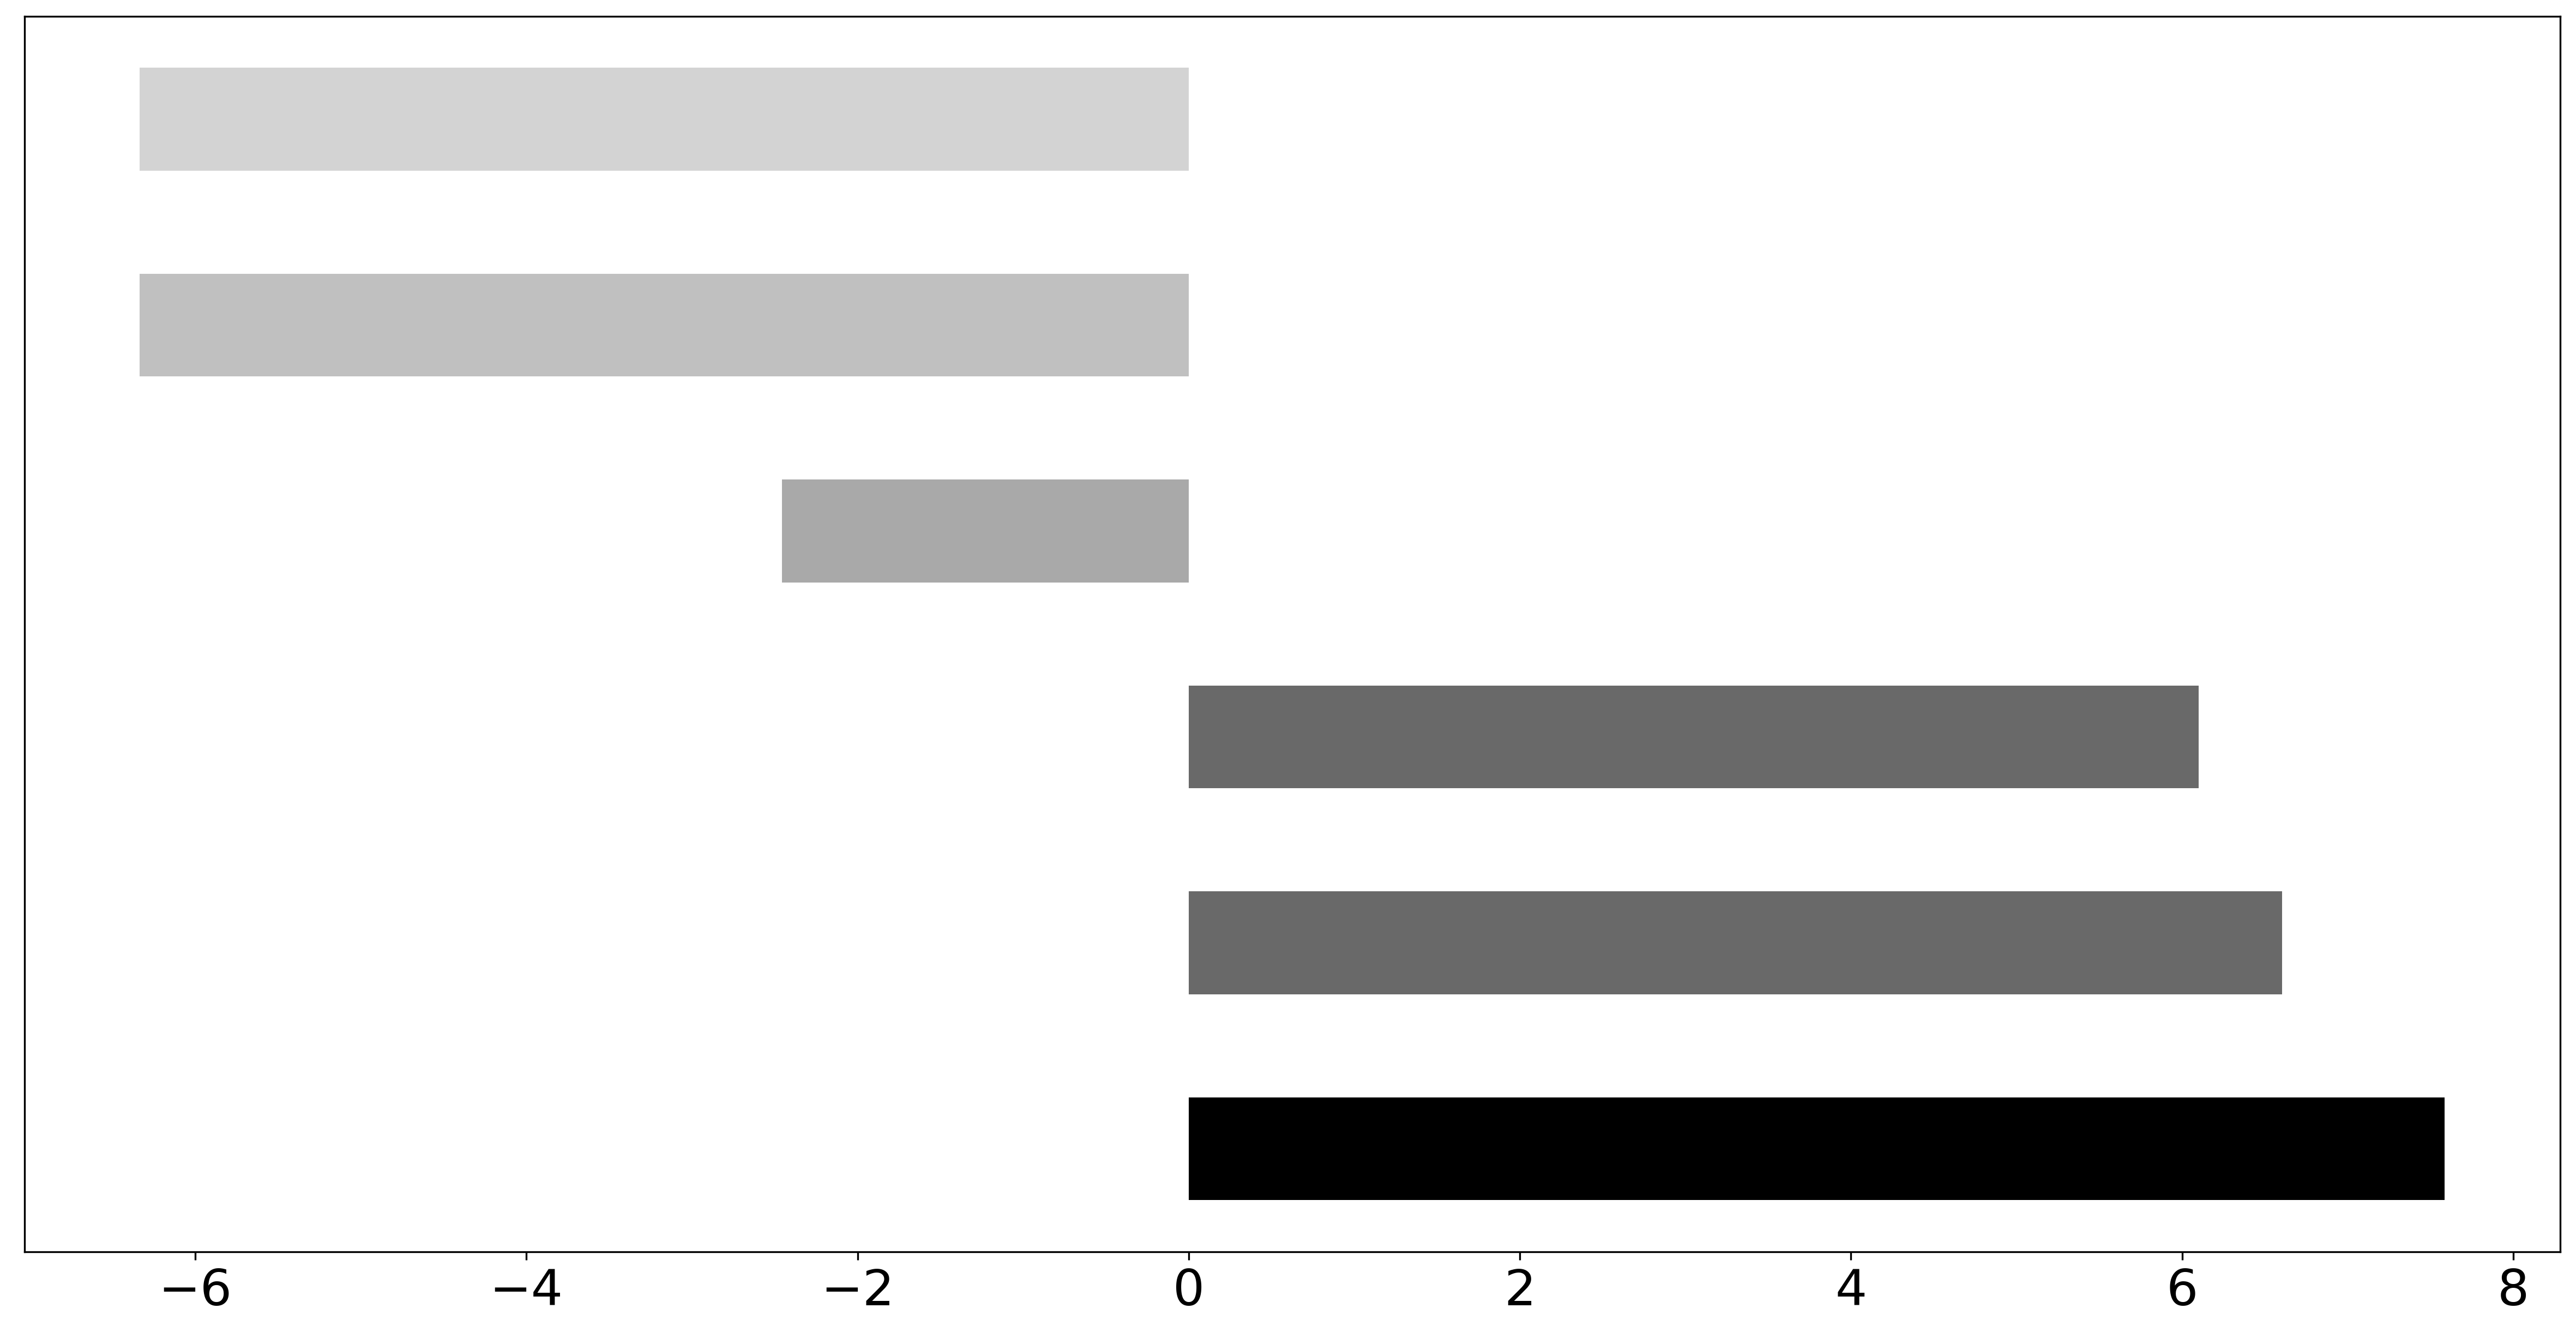

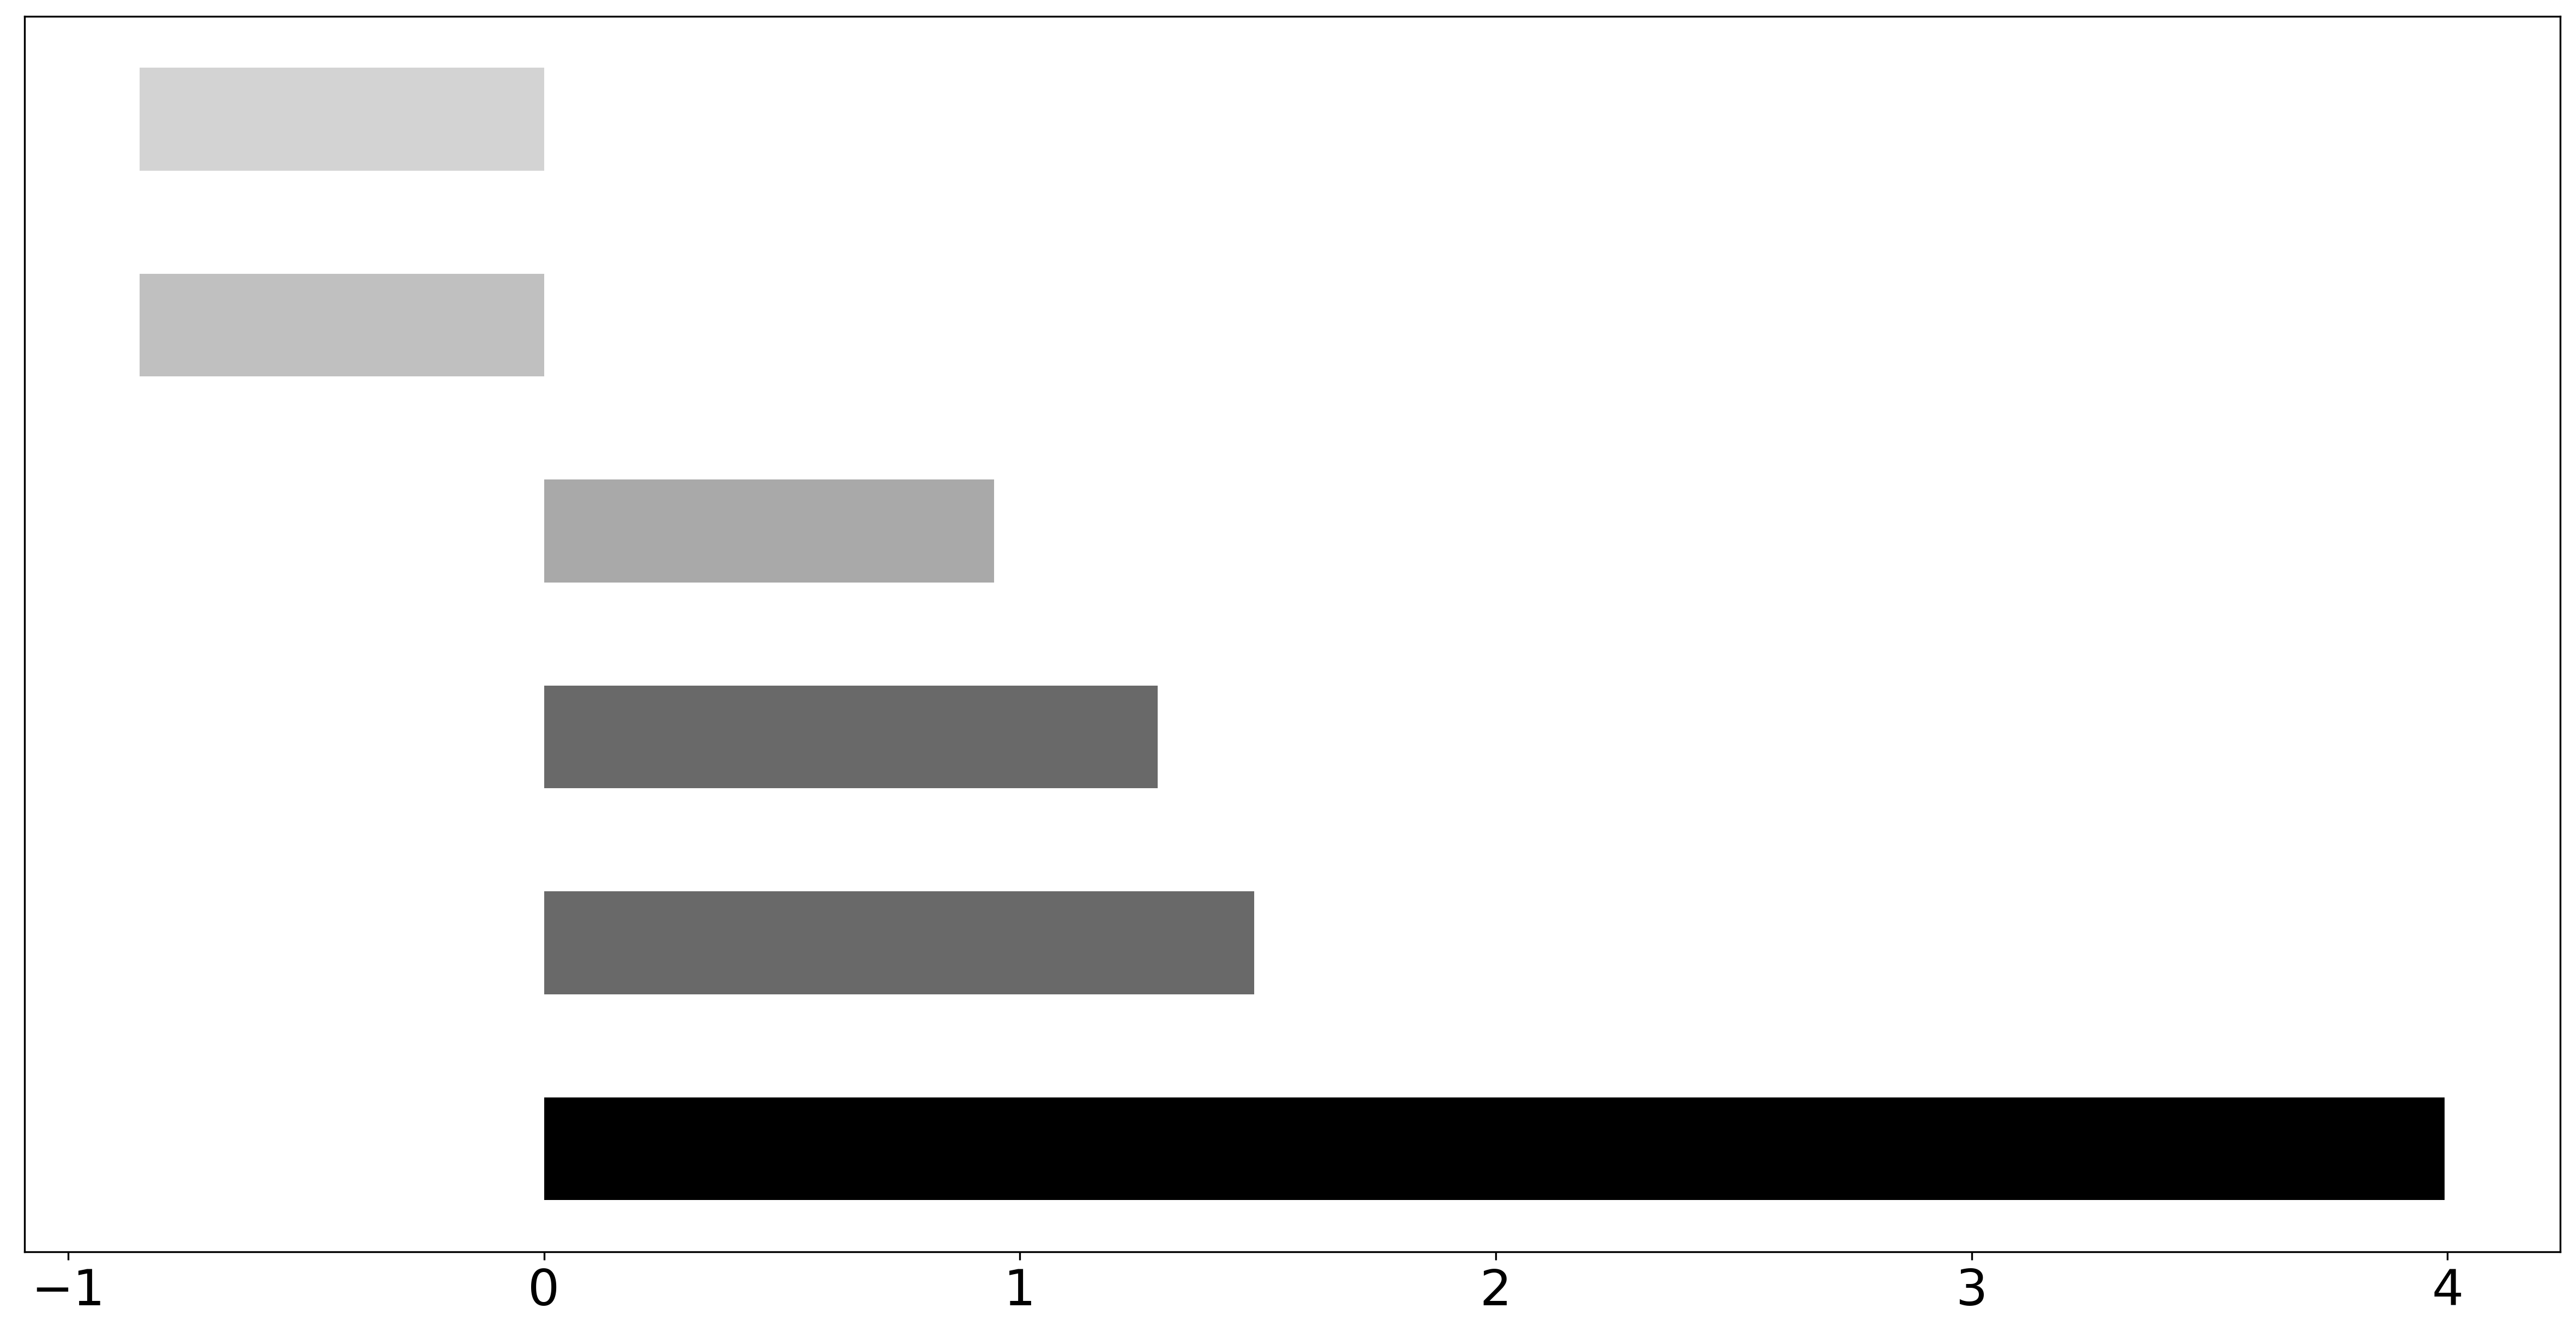

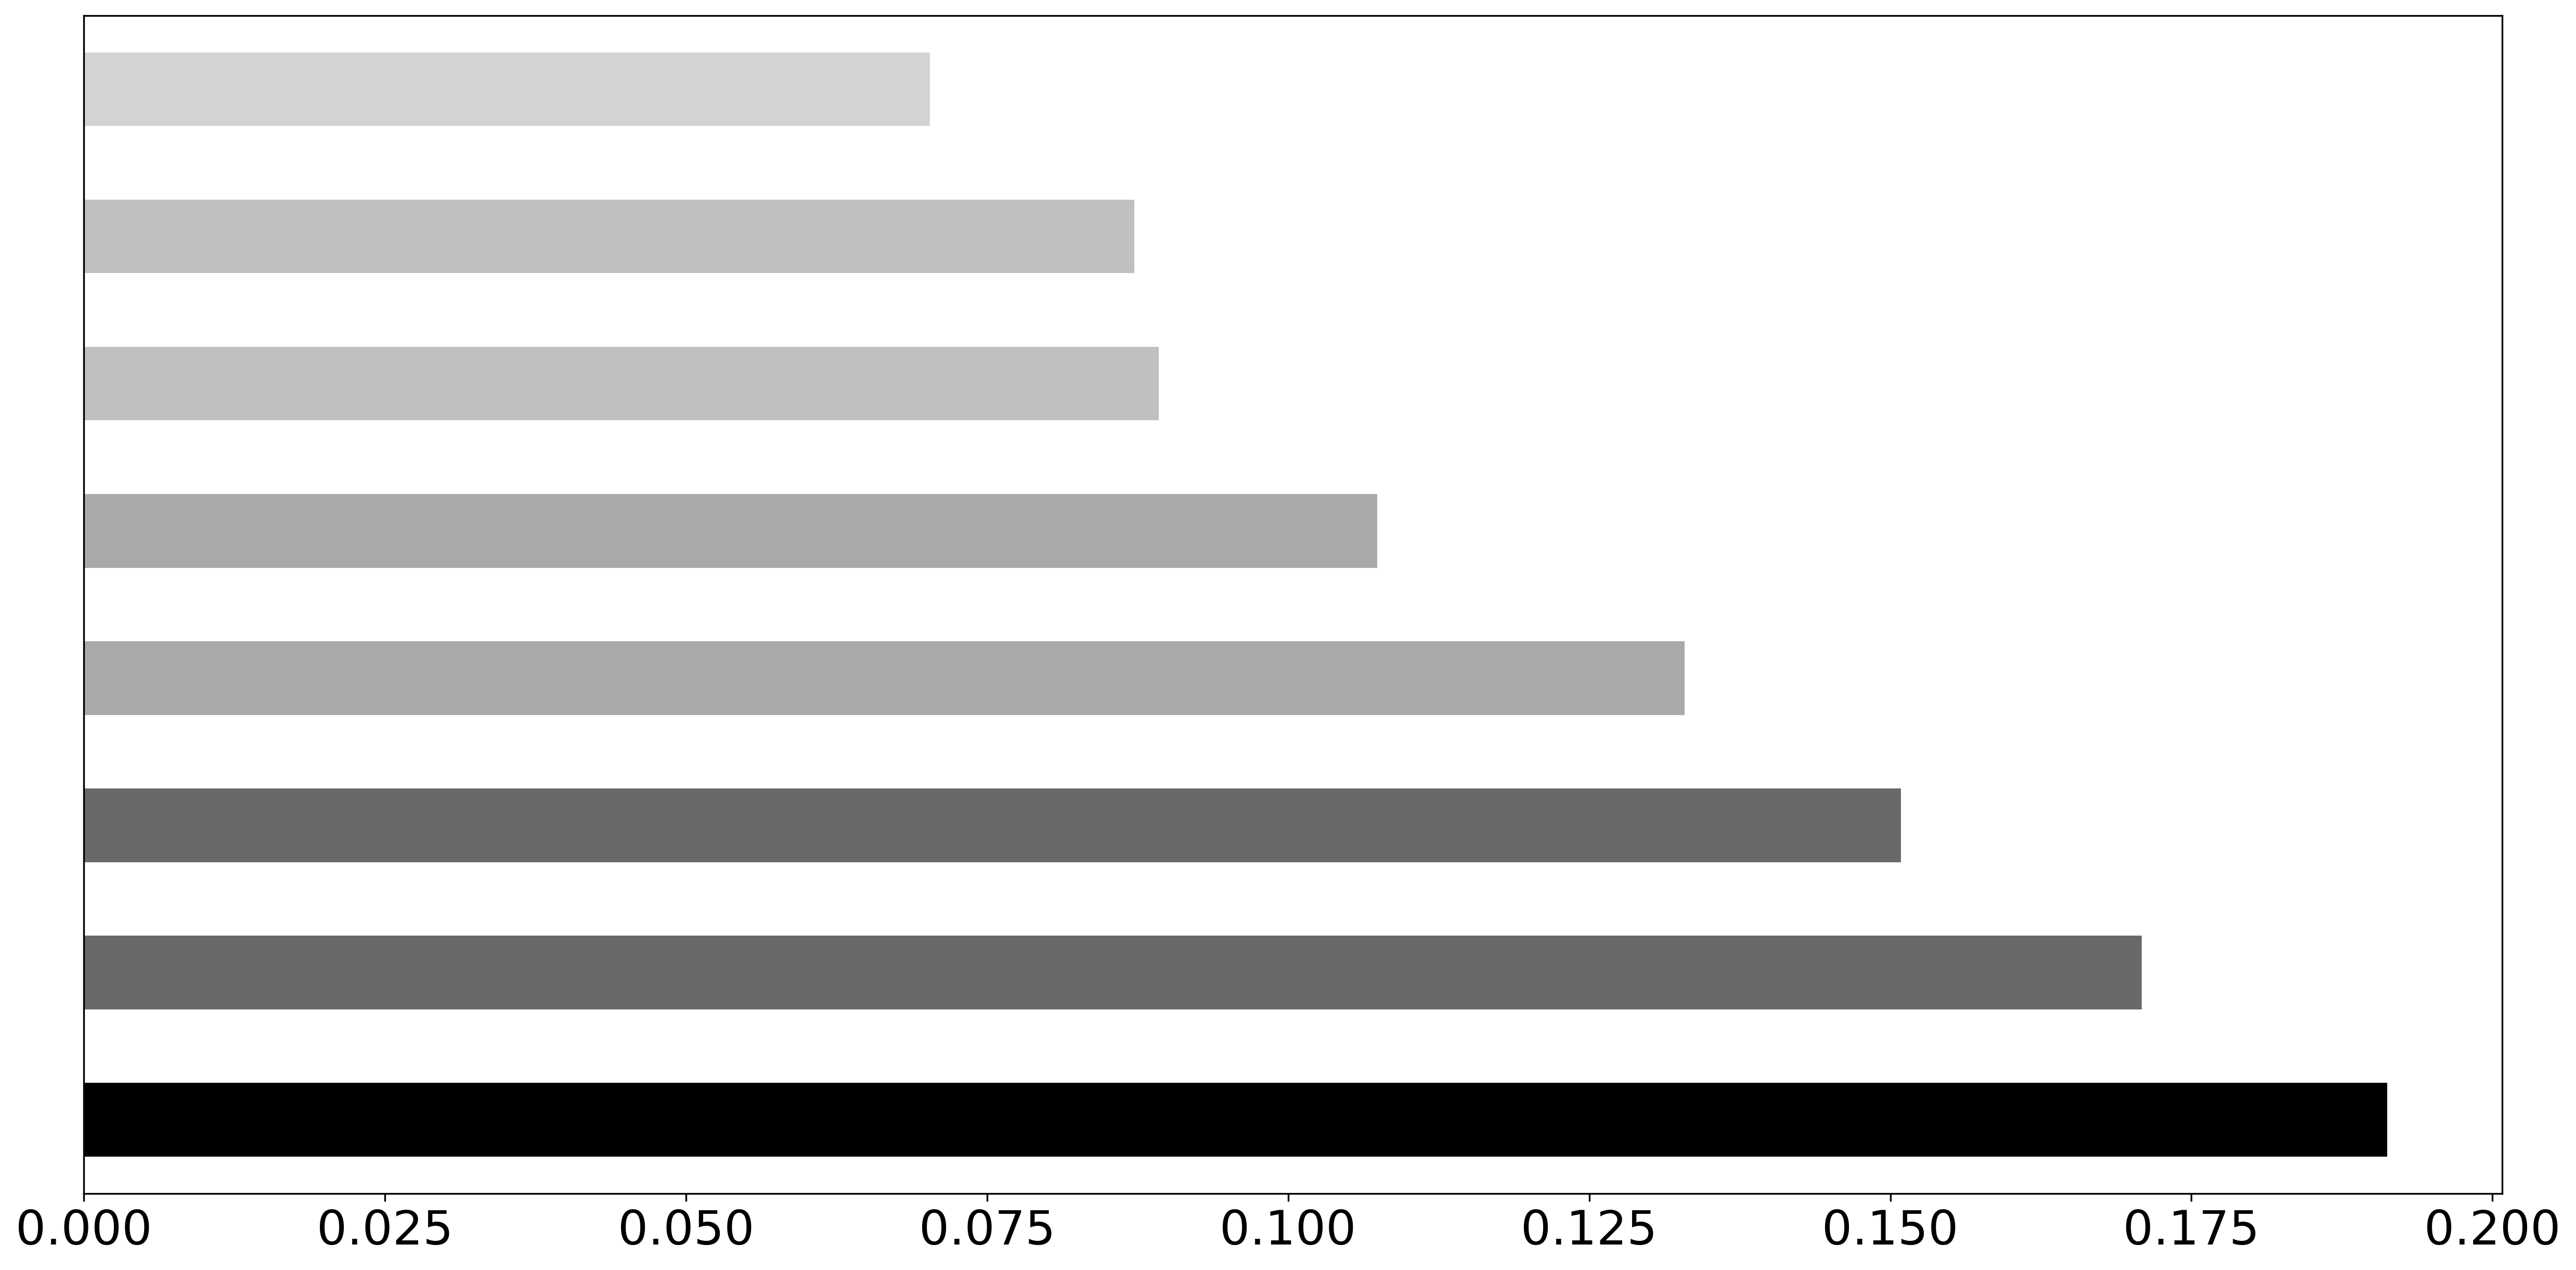

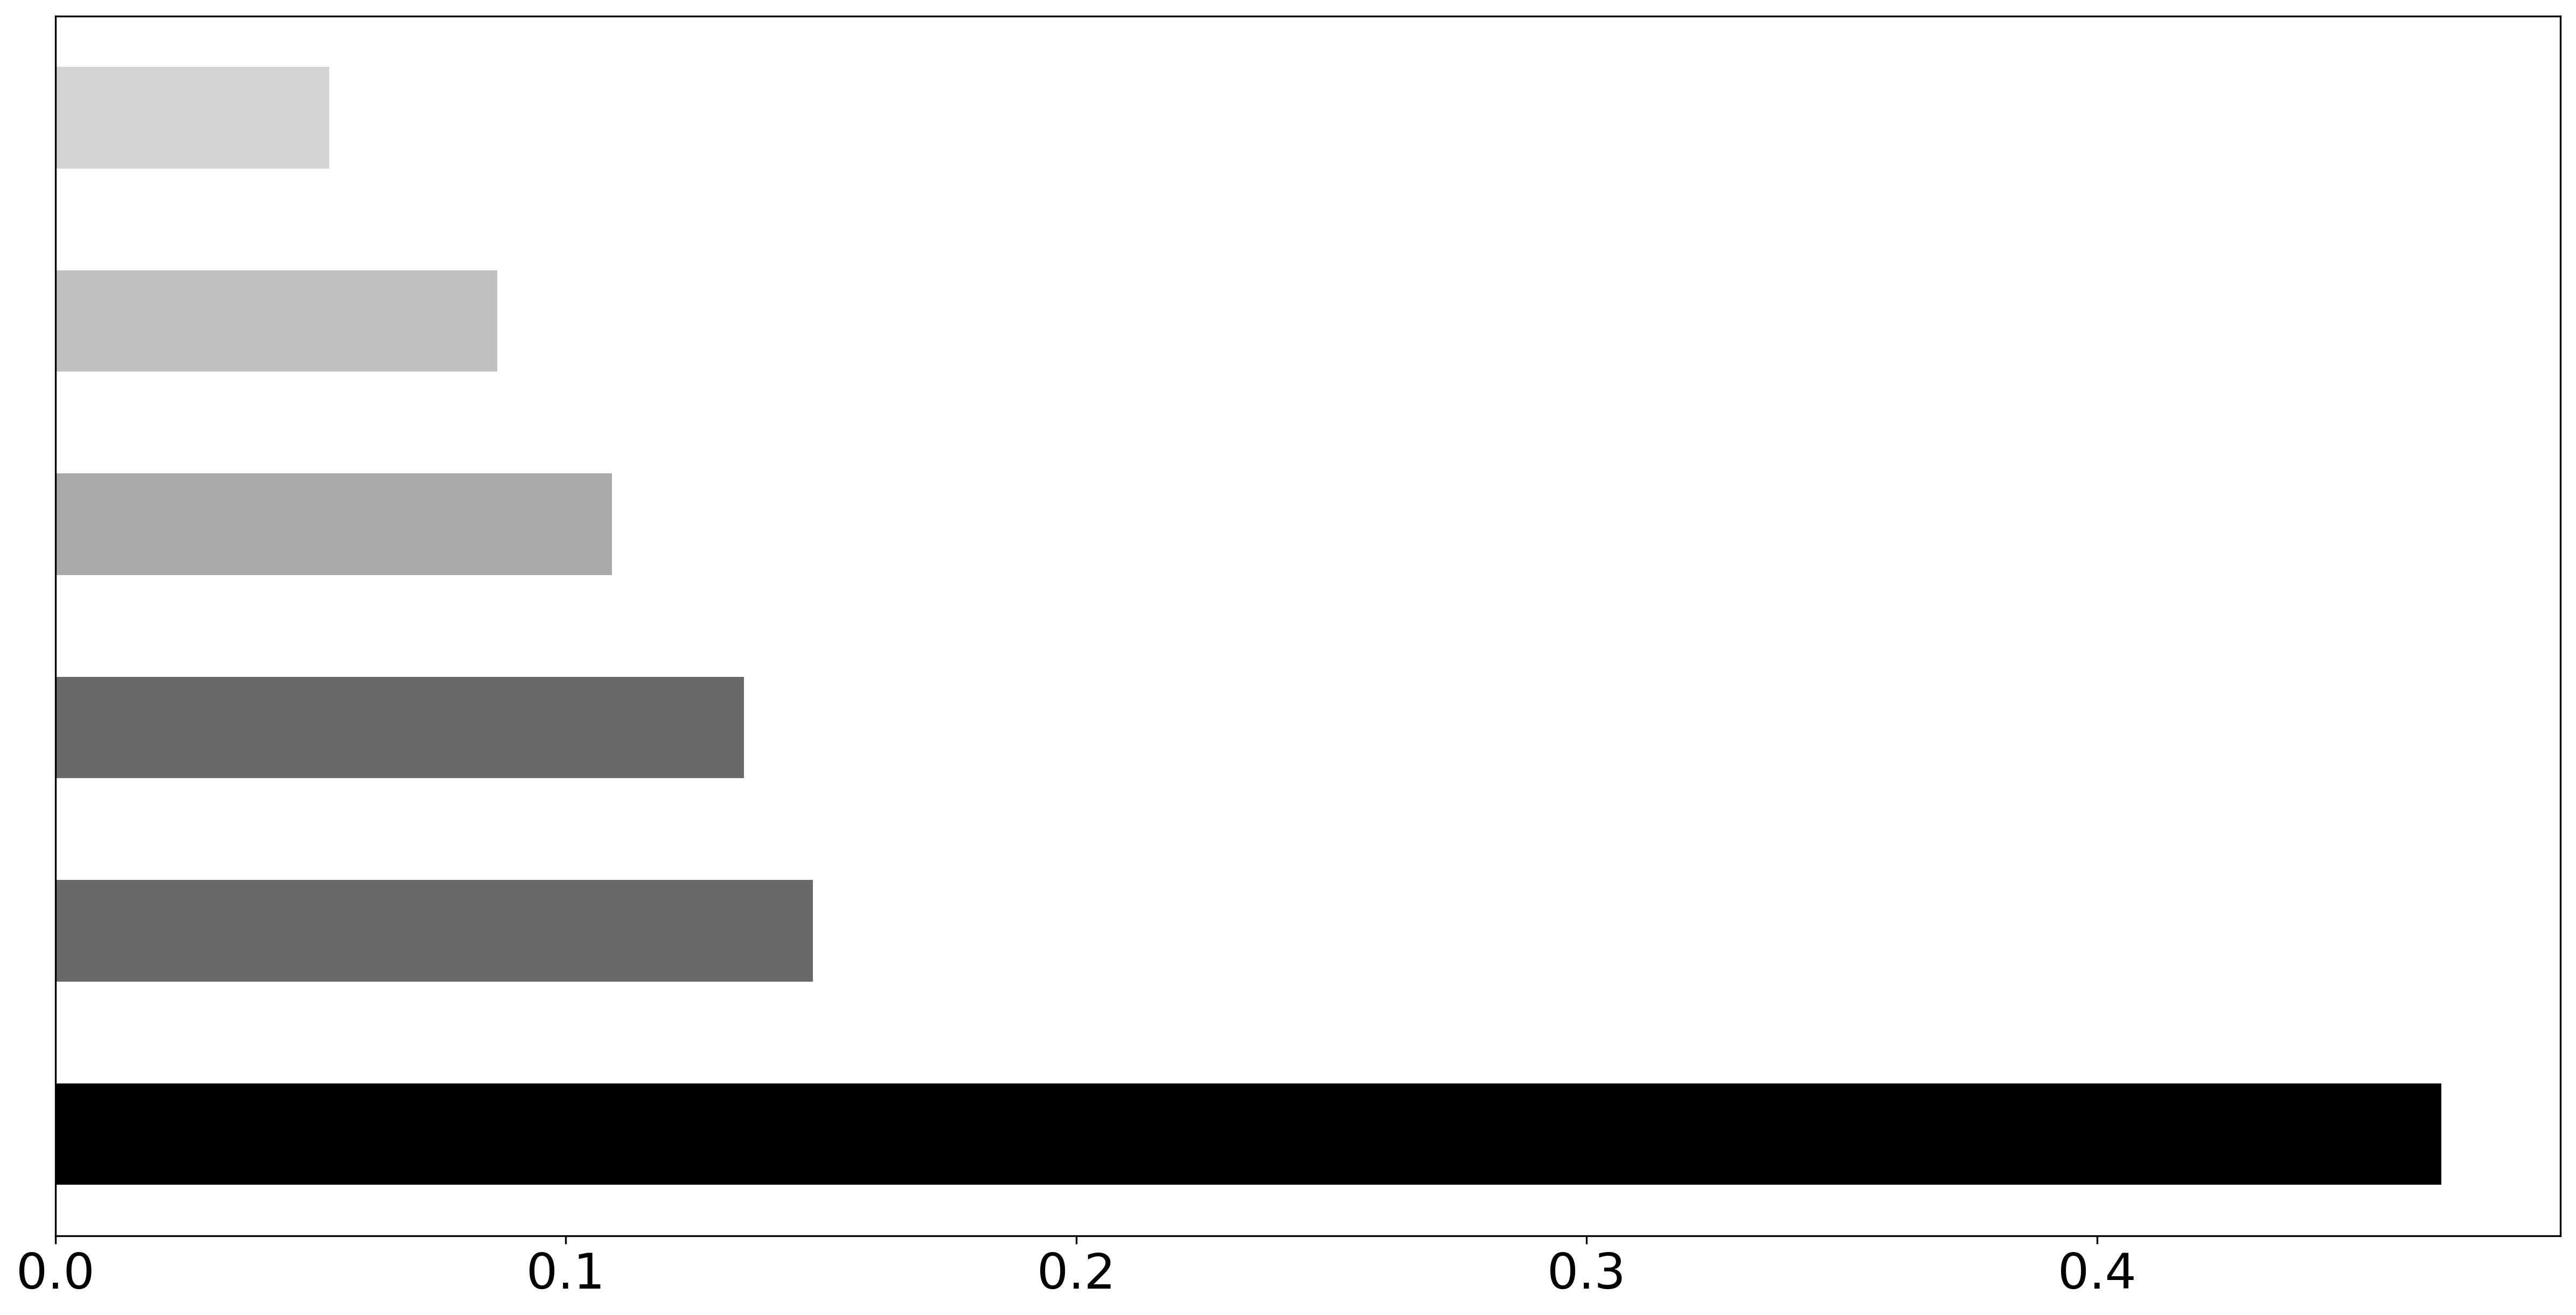

In [105]:
"""
Feature importance (coefficient)
"""
colors6 = ['black','dimgray','dimgrey','darkgray','silver','lightgrey']
colors8 = ['black','dimgray','dimgrey','darkgray','darkgray','silver','silver','lightgrey']
plt.figure(figsize=(20,10), dpi=300)
# plt.subplot(2,2,1)
lr_feat_importances.plot(kind='barh',color=colors6)
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.xticks(fontsize =22)
plt.yticks(fontsize =22)
# plt.show()
plt.savefig('../../data/result/featureImportance_210128_lr_h.png')
# plt.subplot(2,2,2)
plt.figure(figsize=(20,10), dpi=300)
svm_feat_importances.plot(kind='barh',color=colors6)
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.xticks(fontsize =22)
plt.yticks(fontsize =22)
# plt.show()
plt.savefig('../../data/result/featureImportance_210128_svm_h.png')
# plt.subplot(2,2,3)
plt.figure(figsize=(20,10), dpi=300)
rf_feat_importances.plot(kind='barh',color=colors8)
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.xticks(fontsize =22)
plt.yticks(fontsize =22)
# plt.show()
plt.savefig('../../data/result/featureImportance_210128_rf_h.png')
# plt.subplot(2,2,4)
plt.figure(figsize=(20,10), dpi=300)
xgb_feat_importances.plot(kind='barh',color=colors6)
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.xticks(fontsize =22)
plt.yticks(fontsize =22)
plt.savefig('../../data/result/featureImportance_210128_xgb_h.png')
plt.show()


######################################
LR
[21:08:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
acc: 0.8699551569506726 0.8565022421524664 0.9125560538116592 0.874439461883408


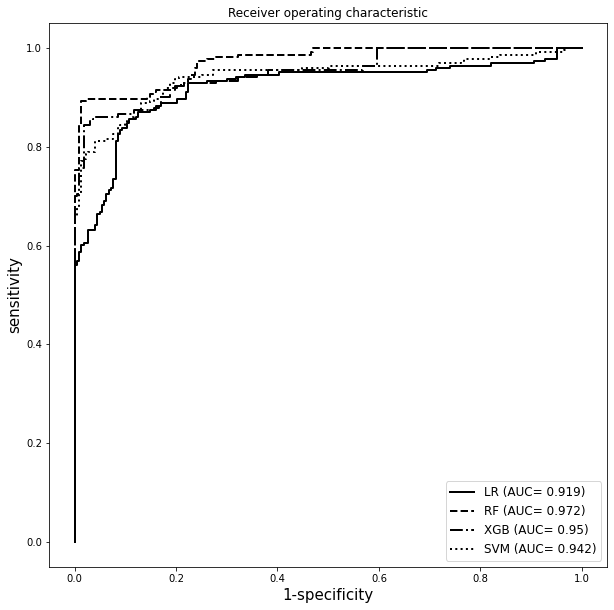

lr_tp, lr_fp, lr_tn, lr_fn, lr_sensitivity, lr_specificity: 192 31 196 27 0.8767123287671232 0.8634361233480177
rf_tp, rf_fp, rf_tn, rf_fn, rf_sensitivity, rf_specificity: 206 17 176 47 0.8142292490118577 0.9119170984455959
xgb_tp, xgb_fp, xgb_tn, xgb_fn, xgb_sensitivity, xgb_specificity: 188 35 219 4 0.9791666666666666 0.8622047244094488
svm_tp, svm_fp, svm_tn, svm_fn, svm_sensitivity, svm_specificity: 186 37 204 19 0.9073170731707317 0.8464730290456431
######################################
RF
[21:08:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
acc: 0.7914798206278026 0.9192825112107623 0.8923766816143498 0.874439461883408


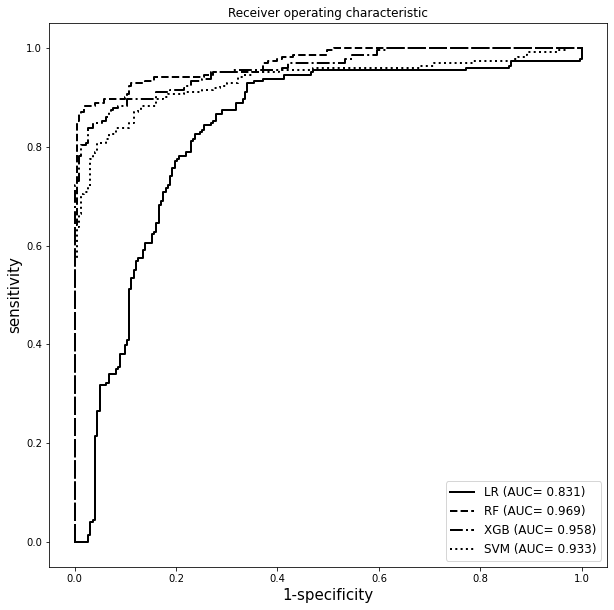

lr_tp, lr_fp, lr_tn, lr_fn, lr_sensitivity, lr_specificity: 188 35 165 58 0.7642276422764228 0.825
rf_tp, rf_fp, rf_tn, rf_fn, rf_sensitivity, rf_specificity: 200 23 210 13 0.9389671361502347 0.9012875536480687
xgb_tp, xgb_fp, xgb_tn, xgb_fn, xgb_sensitivity, xgb_specificity: 181 42 217 6 0.9679144385026738 0.8378378378378378
svm_tp, svm_fp, svm_tn, svm_fn, svm_sensitivity, svm_specificity: 181 42 209 14 0.9282051282051282 0.8326693227091634
######################################
XGB
[21:08:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
acc: 0.7914798206278026 0.9192825112107623 0.8923766816143498 0.874439461883408


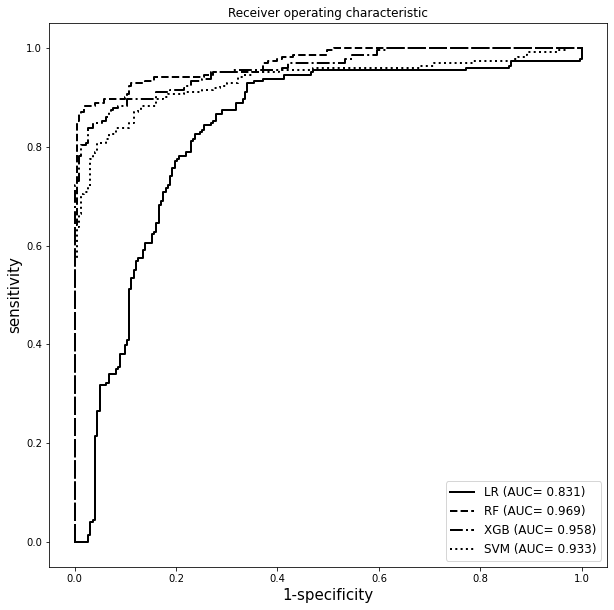

lr_tp, lr_fp, lr_tn, lr_fn, lr_sensitivity, lr_specificity: 188 35 165 58 0.7642276422764228 0.825
rf_tp, rf_fp, rf_tn, rf_fn, rf_sensitivity, rf_specificity: 200 23 210 13 0.9389671361502347 0.9012875536480687
xgb_tp, xgb_fp, xgb_tn, xgb_fn, xgb_sensitivity, xgb_specificity: 181 42 217 6 0.9679144385026738 0.8378378378378378
svm_tp, svm_fp, svm_tn, svm_fn, svm_sensitivity, svm_specificity: 181 42 209 14 0.9282051282051282 0.8326693227091634
######################################
SVM
[21:08:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
acc: 0.8834080717488789 0.8497757847533632 0.8811659192825112 0.8766816143497758


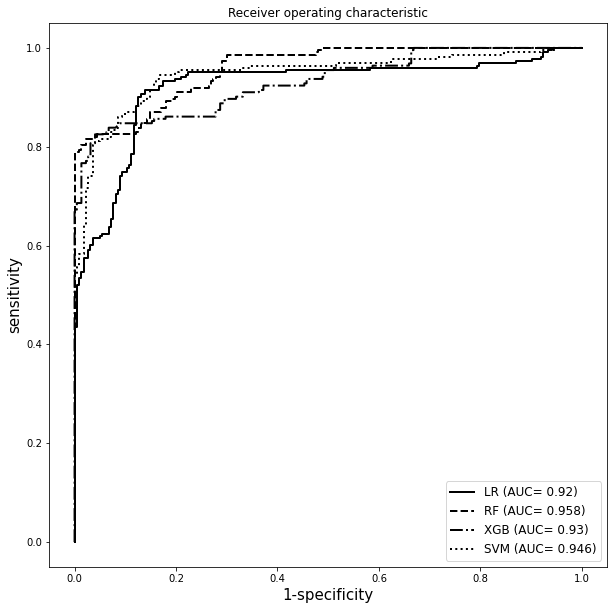

lr_tp, lr_fp, lr_tn, lr_fn, lr_sensitivity, lr_specificity: 199 24 195 28 0.8766519823788547 0.8904109589041096
rf_tp, rf_fp, rf_tn, rf_fn, rf_sensitivity, rf_specificity: 201 22 178 45 0.8170731707317073 0.89
xgb_tp, xgb_fp, xgb_tn, xgb_fn, xgb_sensitivity, xgb_specificity: 185 38 208 15 0.925 0.8455284552845529
svm_tp, svm_fp, svm_tn, svm_fn, svm_sensitivity, svm_specificity: 187 36 204 19 0.9077669902912622 0.85


In [68]:
print('######################################')
print('LR')
lr_select_model= create_curve_select(classlist_lr,lr_train_x,train_y,lr_test_x,test_y,'../../data/result/lr_rfe6_210118')
print('######################################')
print('RF')
rf_select_model= create_curve_select(classlist_rf,rf_train_x,train_y,rf_test_x,test_y,'../../data/result/rf_rfe6_210118')
print('######################################')
print('XGB')
xgb_select_model= create_curve_select(classlist_xgb,xgb_train_x,train_y,xgb_test_x,test_y,'../../data/result/xgb_rfe6_210118')
print('######################################')
print('SVM')
svm_select_model= create_curve_select(classlist_svm,svm_train_x,train_y,svm_test_x,test_y,'../../data/result/svm_rfe6_210118')

In [ ]:
LR_grid={'penalty': ['l1', 'l2'], 
            'C': [0.001, 0.01, 0.1, 1, 10, 100],'random_state' : [0, 15, 25]
                   }

RF_grid={'max_depth': [6,8,10,12], # max_depth: The maximum depth of the tree.
              'n_estimators': [100,200,400], # n_estimators: The number of trees in the forest.
              'min_samples_split': [50, 100,25,75,125],'random_state' : [0, 15, 25]
              }

XGB_grid={'n_estimators' : [200,400,600],
              'learning_rate' : [0.01,0.05,0.10,0.15],
              'max_depth' : [6,8,10,12],'random_state' : [0, 15, 25]} 

SVM_grid = {'gamma': [0.01, 0.1, 1, 10, 100], 
              'C': [0.01, 0.1, 1, 10, 100],'random_state' : [0, 15, 25]}

LR = LogisticRegression()
RF = RandomForestClassifier()
XGB = XGBClassifier()
SVM = SVC()

gridlist = [LR_grid,RF_grid,XGB_grid,SVM_grid]
classlist = [LR,RF,XGB,SVM]

In [ ]:
def gridsearch(gridlist,classlist,train_x,train_y):
    for i in range(4):
        grid = GridSearchCV(classlist[i], gridlist[i], scoring = 'roc_auc', cv=3,n_jobs=-1)  
        grid.fit(train_x, train_y)
        print(grid.best_params_)
        print(grid.best_score_)
        classlist[i] = grid.best_estimator_
    return classlist

In [40]:
print('LR gridsearch')
classlist_lr = gridsearch(gridlist,classlist,lr_train_x,train_y)
print('RF gridsearch')
classlist_rf = gridsearch(gridlist,classlist,rf_train_x,train_y)
print('XGB gridsearch')
classlist_xgb = gridsearch(gridlist,classlist,xgb_train_x,train_y)
print('SVM gridsearch')
classlist_svm = gridsearch(gridlist,classlist,svm_train_x,train_y)

LR gridsearch
{'C': 10, 'penalty': 'l2', 'random_state': 0}
0.8127258529690048
{'max_depth': 10, 'min_samples_split': 75, 'n_estimators': 100, 'random_state': 0}
0.8037857802400739
[01:30:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'random_state': 0}
0.8064347434538263
{'C': 0.1, 'gamma': 1, 'random_state': 0}
0.8190354867024613
RF gridsearch
{'C': 0.1, 'penalty': 'l2', 'random_state': 0}
0.7825798251313794
{'max_depth': 6, 'min_samples_split': 75, 'n_estimators': 100, 'random_state': 0}
0.8191437821323939
[01:31:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with

[01:34:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
acc: 0.8632286995515696 0.9147982062780269 0.8721973094170403 0.8721973094170403


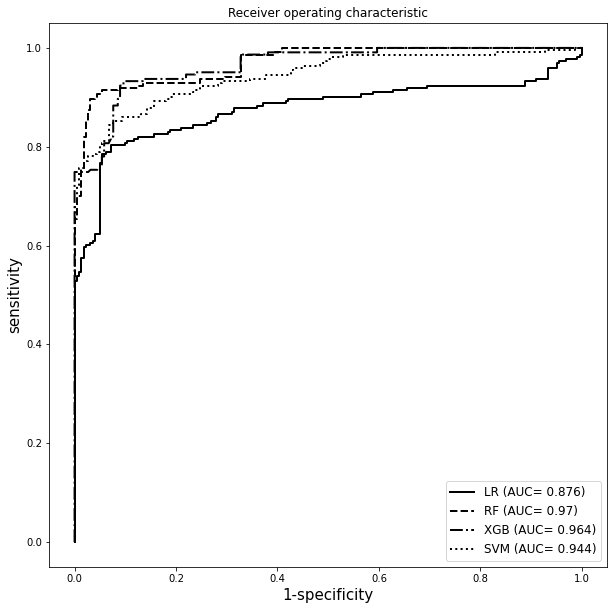

lr_tp, lr_fp, lr_tn, lr_fn, lr_sensitivity, lr_specificity: 178 45 207 16 0.9175257731958762 0.8214285714285714
rf_tp, rf_fp, rf_tn, rf_fn, rf_sensitivity, rf_specificity: 191 32 217 6 0.9695431472081218 0.8714859437751004
xgb_tp, xgb_fp, xgb_tn, xgb_fn, xgb_sensitivity, xgb_specificity: 180 43 209 14 0.9278350515463918 0.8293650793650794
svm_tp, svm_fp, svm_tn, svm_fn, svm_sensitivity, svm_specificity: 170 53 219 4 0.9770114942528736 0.8051470588235294


In [41]:
LR = classlist_lr[0]
RF = classlist_rf[1]
XGB = classlist_xgb[2]
SVM = classlist_svm[3]

LR.fit(lr_train_x,train_y)
RF.fit(rf_train_x,train_y)
XGB.fit(xgb_train_x,train_y)
SVM.fit(svm_train_x,train_y)

lr_proba = LR.predict_proba(lr_test_x)[:,1]
rf_proba = RF.predict_proba(rf_test_x)[:,1]
xgb_proba = XGB.predict_proba(xgb_test_x)[:,1]
# svm_proba = SVM.predict_proba(svm_test_x)[:,1]
svm_proba = SVM.decision_function(svm_test_x)

fpr_lr,tpr_lr,_=roc_curve(test_y,lr_proba)
fpr_rf,tpr_rf,_=roc_curve(test_y,rf_proba)
fpr_xgb,tpr_xgb,_=roc_curve(test_y,xgb_proba)
fpr_svm,tpr_svm,_ = roc_curve(test_y,svm_proba)
# fpr_lgbm,tpr_lgbm,_=roc_curve(test_y,lgbm_proba)

#     print(fpr_svm, tpr_svm)
auc_lr=auc(fpr_lr, tpr_lr)
auc_xgb=auc(fpr_xgb, tpr_xgb)
auc_rf=auc(fpr_rf, tpr_rf)
auc_svm=auc(fpr_svm, tpr_svm)
# auc_lgbm=auc(fpr_lgbm, tpr_lgbm)

lr_pred = LR.predict(lr_test_x)
rf_pred = RF.predict(rf_test_x)
xgb_pred = XGB.predict(xgb_test_x)
svm_pred = SVM.predict(svm_test_x)
# print("Accuracy(C=100): {}%".format(clf_100.score(X_test, y_test) * 100 ))

lr_acc= accuracy_score(test_y,lr_pred)
rf_acc= accuracy_score(test_y,rf_pred)
xgb_acc= accuracy_score(test_y,xgb_pred)
svm_acc= accuracy_score(test_y,svm_pred)

# print('acc:', lr_acc,rf_acc, xgb_acc, SVM.score(test_x, test_y))
print('acc:', lr_acc,rf_acc, xgb_acc, svm_acc)

plt.figure(figsize=(10,10))
plt.plot(fpr_lr, tpr_lr, '-k', label="LR (AUC= %s)"%(round(auc_lr,3)), linewidth=2)
plt.plot(fpr_rf, tpr_rf, '--k', label="RF (AUC= %s)"%(round(auc_rf,3)), linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, '-.k', label="XGB (AUC= %s)"%(round(auc_xgb,3)), linewidth=2,)
plt.plot(fpr_svm, tpr_svm, ':k', label="SVM (AUC= %s)"%(round(auc_svm,3)), linewidth=2,)
# plt.plot(fpr_lgbm, tpr_lgbm, label="S.ESB (AUC= %s)"%(round(auc_lgbm,3)))
#     plt.xlim([0.0 , 1.0])
#     plt.ylim([0.5, 1.0])
plt.xlabel('1-specificity',fontsize=15)
plt.ylabel('sensitivity',fontsize=15)
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right",fontsize=12)
plt.savefig('../../data/result/each_rfe_min_210119', dpi=300, facecolor='w', edgecolor='w')
plt.show()

lr_tp, lr_fp, lr_tn, lr_fn, lr_sensitivity, lr_specificity= calculate_performance(lr_pred, test_y)
rf_tp, rf_fp, rf_tn, rf_fn, rf_sensitivity, rf_specificity= calculate_performance(rf_pred, test_y)
xgb_tp, xgb_fp, xgb_tn, xgb_fn, xgb_sensitivity, xgb_specificity= calculate_performance(xgb_pred, test_y)
svm_tp, svm_fp, svm_tn, svm_fn, svm_sensitivity, svm_specificity= calculate_performance(svm_pred, test_y)    ##########

print('lr_tp, lr_fp, lr_tn, lr_fn, lr_sensitivity, lr_specificity:', lr_tp, lr_fp, lr_tn, lr_fn, lr_sensitivity, lr_specificity)
print('rf_tp, rf_fp, rf_tn, rf_fn, rf_sensitivity, rf_specificity:', rf_tp, rf_fp, rf_tn, rf_fn, rf_sensitivity, rf_specificity)
print('xgb_tp, xgb_fp, xgb_tn, xgb_fn, xgb_sensitivity, xgb_specificity:',xgb_tp, xgb_fp, xgb_tn, xgb_fn, xgb_sensitivity, xgb_specificity)
print('svm_tp, svm_fp, svm_tn, svm_fn, svm_sensitivity, svm_specificity:', svm_tp, svm_fp, svm_tn, svm_fn, svm_sensitivity, svm_specificity)


[ 0.0345639   0.          0.          0.         -0.          0.13780842
  0.76984362 -0.          0.          0.          0.          0.
 -0.          0.          0.30823399  0.         -0.          0.
 -0.          0.53813618 -0.          0.         -0.          0.
  0.          0.          0.         -0.         -0.          0.
  0.          0.          0.         -0.         -0.          0.16158943
  0.          0.          0.         -0.          0.         -0.        ]
Lasso(alpha=0.001, normalize=True)


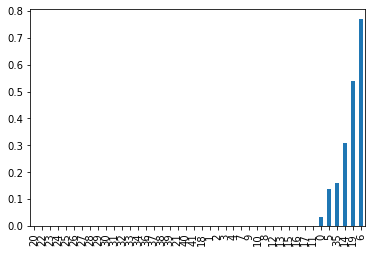

In [39]:
from sklearn.linear_model import Lasso, Ridge

lassoReg = Lasso(alpha=0.001, normalize = True)

lassoReg.fit(train_x, train_y)
print(lassoReg.coef_)
coef = pd.Series(lassoReg.coef_).sort_values()
coef.plot(kind = 'bar')

print(lassoReg)

In [9]:
ftr_importances = eli5.format_as_dataframe(eli5.explain_weights(lassoReg,top=20, feature_names = test_x.columns.tolist()))
print(ftr_importances)   ###sorting 
ftr_top = ftr_importances.sort_values(ascending=False,by='feature')[:]
print(ftr_top)

  target                   feature    weight
0      y       First_Order_Maximum  0.769844
1      y         GLCM_ClusterShade  0.538136
2      y      First_Order_Skewness  0.308234
3      y                 GLCM_Idmn  0.161589
4      y      First_Order_Kurtosis  0.137808
5      y  First_Order_10Percentile  0.034564
6      y                    <BIAS> -0.811071
  target                   feature    weight
3      y                 GLCM_Idmn  0.161589
1      y         GLCM_ClusterShade  0.538136
2      y      First_Order_Skewness  0.308234
0      y       First_Order_Maximum  0.769844
4      y      First_Order_Kurtosis  0.137808
5      y  First_Order_10Percentile  0.034564
6      y                    <BIAS> -0.811071


[15:07:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
acc: 0.7511210762331838 0.8789237668161435 0.8856502242152466 0.7757847533632287


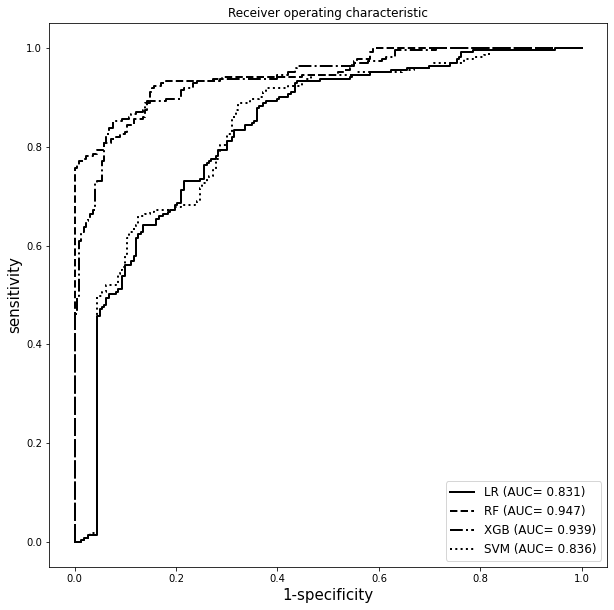

lr_tp, lr_fp, lr_tn, lr_fn, lr_sensitivity, lr_specificity: 174 49 161 62 0.7372881355932204 0.7666666666666667
rf_tp, rf_fp, rf_tn, rf_fn, rf_sensitivity, rf_specificity: 174 49 218 5 0.9720670391061452 0.8164794007490637
xgb_tp, xgb_fp, xgb_tn, xgb_fn, xgb_sensitivity, xgb_specificity: 189 34 206 17 0.9174757281553398 0.8583333333333333
svm_tp, svm_fp, svm_tn, svm_fn, svm_sensitivity, svm_specificity: 195 28 151 72 0.7303370786516854 0.8435754189944135


In [35]:
###########final
select_model= create_curve_select(classlist_1,train_x_1,train_y_1,test_x_1,test_y_1,'../../data/result/roc_lasso_bw_20210118_check_2')